In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# 點擊圖片的位置，回傳該點座標
def click_event(event, x, y, flags, params):
    
    # 使用全域變數紀錄
    global count, points
    
    # 判斷是左鍵點擊，且不超過四次
    if  count < 4 and event == cv2.EVENT_LBUTTONDOWN:
        
        # 將座標記錄下來
        points.append([y,x])
        count += 1

        print(y, ' ', x)

        # 顯示在圖上
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cv2.putText(img, str(x) + ',' +
					str(y), (x,y), font,
					1, (255, 0, 0), 2)
                    
        cv2.imshow('image', img)

In [30]:
# 全域變數
count = 0
points = []

# 讀入圖片
img = cv2.imread('image.jpg', 1)

# 視窗顯示圖片
cv2.imshow('image', img)

# 點擊紀錄座標
cv2.setMouseCallback('image', click_event)

# 關閉視窗
cv2.waitKey(0)
cv2.destroyAllWindows()

182   218
78   443
358   236
270   472


In [31]:
# 來源點四座標/目標點四座標
pointsSrc = np.array(points)
pointsDst  = np.array([[0, 0], [0, 599],[449, 0], [449, 599]])

print(pointsSrc)
print(pointsDst)

[[182 218]
 [ 78 443]
 [358 236]
 [270 472]]
[[  0   0]
 [  0 599]
 [449   0]
 [449 599]]


In [32]:
# 利用四個座標轉換，解八個未知數
src_points = pointsSrc.astype(np.float32)
dst_points = pointsDst.astype(np.float32)

# 來源對應到目標轉換矩陣
H1 = cv2.getPerspectiveTransform(src_points, dst_points)

print(H1)

print('\n')

# 驗算

for i in range(4):
    x1, y1, z1 = H1 @ np.array([pointsSrc[i][0], pointsSrc[i][1], 1])

    x1 = int(round(x1 / z1))
    y1 = int(round(y1 / z1))

    print(pointsSrc[i][0], pointsSrc[i][1], '->', x1, y1)

print('\n')

# 目標對應到來源轉換矩陣
H2 = cv2.getPerspectiveTransform(dst_points, src_points)

print(H2)


print('\n')

# 驗算

for i in range(4):
    x2, y2, z2 = H2 @ np.array([pointsDst[i][0], pointsDst[i][1], 1])

    x2 = int(round(x2 / z2))
    y2 = int(round(y2 / z2))

    print(pointsDst[i][0], pointsDst[i][1], '->', x2, y2)

[[ 2.96038065e+00  1.36835372e+00 -8.37090391e+02]
 [-3.38634832e-01  3.31109614e+00 -6.60187419e+02]
 [ 1.70979760e-04  6.52804100e-04  1.00000000e+00]]


182 218 -> 0 0
78 443 -> 0 599
358 236 -> 449 0
270 472 -> 449 599


[[ 3.64529493e-01 -1.86529055e-01  1.82000000e+02]
 [ 2.19917830e-02  3.02324589e-01  2.18000000e+02]
 [-7.66834911e-05 -1.65466038e-04  1.00000000e+00]]


0 0 -> 182 218
0 599 -> 78 443
449 0 -> 358 236
449 599 -> 270 472


# 手刻直接對應

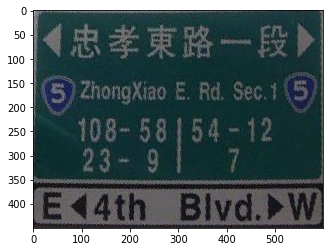

In [33]:
# 讀取圖片

img = cv2.imread("image.jpg")

img_transformed = np.empty((450, 600, 3), dtype=np.uint8)

# 轉換矩陣 > 目標對應到來源轉換矩陣 > 避免掉點
H2 = cv2.getPerspectiveTransform(dst_points, src_points)

for i in range(img_transformed.shape[0]):
    for j in range(img_transformed.shape[1]):
        i_out, j_out, z = H2 @ np.array([i, j, 1])
        i_out = int(round(i_out / z))
        j_out = int(round(j_out / z))
        img_transformed[i, j, :] = img[i_out, j_out, :]

cv2.imwrite('img_transformed_mapping.jpg', img_transformed)

img_transformed = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB)

plt.imshow(img_transformed)
plt.show()

# 手刻 nearest neighbors

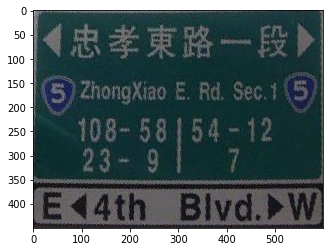

In [34]:
# 讀取圖片

img = cv2.imread("image.jpg", 1)

# nearest neighbors interpolation 最近鄰插值
def nearest_neighbors(i, j, M, T):
    x_max, y_max = M.shape[0] - 1, M.shape[1] - 1
    x, y, z = T @ np.array([i, j, 1])

    x = x / z
    y = y / z

    # 本身就是整數
    if np.floor(x) == x and np.floor(y) == y:
        x, y = int(x), int(y)
        return M[x, y, :]

    # np.floor() 向下取整數, np.ceil() 向上取整數
    if np.abs(np.floor(x) - x) < np.abs(np.ceil(x) - x):
        x = int(np.floor(x))
    else:
        x = int(np.ceil(x))

    if np.abs(np.floor(y) - y) < np.abs(np.ceil(y) - y):
        y = int(np.floor(y))
    else:
        y = int(np.ceil(y))

    return M[x, y, :]

img_transformed = np.empty((450, 600, 3), dtype=np.uint8)

# 轉換矩陣 > 目標對應到來源轉換矩陣 > 避免掉點
H2 = cv2.getPerspectiveTransform(dst_points, src_points)

for i in range(img_transformed.shape[0]):
    for j in range(img_transformed.shape[1]):
        img_transformed[i, j, :] = nearest_neighbors(i, j, img, H2)
        
cv2.imwrite('img_transformed_nearest_neighbors.jpg', img_transformed)

img_transformed = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB)
plt.imshow(img_transformed)
plt.show()

# 手刻 bilinear

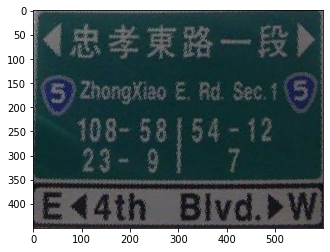

In [35]:
# 讀取圖片

img = cv2.imread("image.jpg", 1)

# bilinear interpolation 雙線性插值
def GetBilinearPixel(i, j, M, T):
    x, y, z = T @ np.array([i, j, 1])
    x = x / z
    y = y / z
    
    # 向上整數部分
    xf = int(np.floor(x))
    yf = int(np.floor(y))

    # 向下整數部分
    xc = int(np.ceil(x))
    yc = int(np.ceil(y))

    # 小數部分
    u = x - xf
    v = y - yf

    # 雙線性插值
    result = M[xf, yf, :] * (1 - u) * (1 - v) + \
             M[xc, yf, :] * (1 - u) * v + \
             M[xf, yc, :] * u * (1 - v) + \
             M[xc, yc, :] * u * v
    
    return result

img_transformed = np.empty((450, 600, 3), dtype=np.uint8)

# 轉換矩陣 > 目標對應到來源轉換矩陣 > 避免掉點
H2 = cv2.getPerspectiveTransform(dst_points, src_points)

for i in range(img_transformed.shape[0]):
    for j in range(img_transformed.shape[1]):
        img_transformed[i, j, :] = GetBilinearPixel(i, j, img, H2)

cv2.imwrite('img_transformed_bilinear.jpg', img_transformed)

img_transformed = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB)
plt.imshow(img_transformed)
plt.show()

# 使用 opencv 套件，完成透視變形校正

In [36]:
# 讀取圖片
img = cv2.imread("image.jpg", 1)

# 得到圖片的高跟寬
img_height, img_width = img.shape[:2]

# 來源點四座標/目標點四座標
pointsSrcSwap = pointsSrc.copy()
pointsDstSwap = pointsDst.copy()
pointsSrcSwap[:, [1, 0]] = pointsSrcSwap[:, [0, 1]]
pointsDstSwap[:, [1, 0]] = pointsDstSwap[:, [0, 1]]
srcSwap_points = pointsSrcSwap.astype(np.float32)
dstSwap_points = pointsDstSwap.astype(np.float32)

# 轉換矩陣 > 來源對應到目標轉換矩陣 > 套件要求
H = cv2.getPerspectiveTransform(srcSwap_points, dstSwap_points)

# 透視變形校正
processed = cv2.warpPerspective(img,  H, (img_width, img_height))

# 顯示處理前後圖
cv2.imshow("org", img)
cv2.imshow("processed", processed)
cv2.imwrite('img_transformed_opencv.jpg', processed)

cv2.waitKey(0)
cv2.destroyAllWindows()